In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [6]:
import pandas as pd
import os
import glob
import numpy as np
import re
from time import time
import random
from string import punctuation, whitespace
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [9]:
# Run to check if GPU is available

%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


## **Method 1: Using tokenization and Deep Learning**

In [11]:
data = pd.read_csv('/content/drive/MyDrive/tweets.csv', encoding = "ISO-8859-1")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [13]:
#Set column names of the data
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'tweet']
data.head()

,target,ids,date,flag,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [14]:
#Drop columns which would not be useful to us
data = data.drop(['date', 'flag', 'user'], axis = 1)
data.head()

,target,ids,tweet
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [15]:
#Find out unique labels in the target column which represents the sentiment of the tweet
data.target.unique()

array([0, 4])

In [16]:
#Check if null values are present
data.isnull().sum()

target    0
ids       0
tweet     0
dtype: int64

#### **Prepare and process the data**

In [17]:
data.head()

,target,ids,tweet
0,0,1467810672,is upset that he can't update his Facebook by ...
1,0,1467810917,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,my whole body feels itchy and like its on fire
3,0,1467811193,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,@Kwesidei not the whole crew


In [18]:
#Function to extract tweets and corresponding labels in separate arrays
def get_data(dataset):
    tweets = [x for x in dataset['tweet']]
    labels = [x for x in dataset['target']]
    return tweets, labels

In [19]:
tweets, labels = get_data(data)

In [20]:
#Vectorize a text corpus, by turning each text into either a sequence of integers
#(each integer being the index of a token in a dictionary) or into a vector

#OOV token = Unknown represents that unknown words will be added to word_index 
#and used to replace out-of-vocabulary words during text_to_sequence calls
tokenizer = Tokenizer(num_words = 100000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

#Transforms each text in texts to a sequence of integers. Only top num_words-1 most frequent words will be taken into account.
print(tokenizer.texts_to_sequences([tweets[0]]))

[[9, 819, 18, 112, 70, 566, 194, 537, 127, 2098, 10, 7, 300, 552, 86, 5, 2400, 150, 41, 274, 1171]]


#### **Check the length of tweets and create padded sequences**

(array([2.97820e+04, 5.00540e+04, 1.44394e+05, 8.56210e+04, 8.76110e+04,
        1.73556e+05, 8.25290e+04, 8.00670e+04, 1.47396e+05, 6.76510e+04,
        1.23667e+05, 5.62490e+04, 5.39520e+04, 1.03377e+05, 4.82160e+04,
        4.77340e+04, 8.94500e+04, 3.91190e+04, 3.20640e+04, 3.94130e+04,
        9.19200e+03, 7.10600e+03, 9.64000e+02, 4.15000e+02, 2.30000e+02,
        3.60000e+01, 2.70000e+01, 3.00000e+01, 9.00000e+00, 1.90000e+01,
        5.00000e+00, 3.00000e+00, 9.00000e+00, 3.00000e+00, 3.00000e+00,
        4.00000e+00, 5.00000e+00, 1.00000e+00, 4.00000e+00, 1.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        2.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

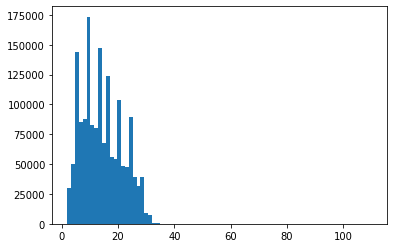

In [21]:
sizes = [len(tweet.split(' ')) for tweet in tweets]
plt.hist(sizes, bins = len(set(sizes)))

#### **This shows that the maximum length of tweets is around 35**

In [22]:
#Create a function to create padded sequences from text
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', maxlen=35, padding='post')
    return padded

In [23]:
padded_sequences = get_sequences(tokenizer, tweets)

In [24]:
padded_sequences[10], padded_sequences[100], padded_sequences[1000]

(array([   2,   21,  685, 6467,    6, 1944,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32),
 array([   1,    2,   99,   93,   58, 6765,    4, 9114,  737,  309,   26,
         315,    5,  548,   49,    4,  637, 4852,  795,  364,   11,   75,
         224,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32),
 array([  20,  186,    6,  634,   43, 1074, 1356,  301,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32))

#### **Prepare Labels**

In [25]:
classes = set(labels)
print(classes)

{0, 4}


(array([799999.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 800000.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

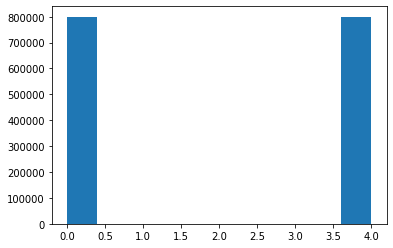

In [32]:
plt.hist(labels)

In [35]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [36]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)
print(train_labels[28])

0


#### **Model Creation**

In [33]:
#Create a sequential model using LSTMs to predict sentiment
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 16, input_length=35),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(15)),
    tf.keras.layers.Dense(6, activation='relu')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 16)            800000    
                                                                 
 bidirectional (Bidirectiona  (None, 35, 30)           3840      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 186       
                                                                 
Total params: 809,546
Trainable params: 809,546
Non-trainable params: 0
_________________________________________________________________


In [37]:
h = model.fit(
    padded_sequences, train_labels,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='acc', patience=2)
    ]
)

Epoch 1/3
50000/50000 [==============================] - 608s 12ms/step - loss: 0.4333 - acc: 0.8055
Epoch 2/3
50000/50000 [==============================] - 584s 12ms/step - loss: 0.3787 - acc: 0.8341
Epoch 3/3
50000/50000 [==============================] - 573s 11ms/step - loss: 0.3603 - acc: 0.8433


## **Method 2: Using CatBoost**

In [39]:
data = pd.read_csv('/content/drive/MyDrive/tweets.csv', encoding = "ISO-8859-1")
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'tweet']
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,target,ids,date,flag,user,tweet
761882,0,2297527529,Tue Jun 23 10:33:10 PDT 2009,NO_QUERY,KiraAlena,i need love...
383328,0,2053173632,Sat Jun 06 03:33:47 PDT 2009,NO_QUERY,vince_alva,well im back... my family left me! (TEARS) (c...
342713,0,2015312587,Wed Jun 03 04:19:19 PDT 2009,NO_QUERY,sweetiedarling1,i no say hi to soph and rach for me
582405,0,2214600083,Wed Jun 17 16:58:25 PDT 2009,NO_QUERY,tmray,Cancelled plans to make other plans then those...
977450,4,1833737115,Mon May 18 00:16:50 PDT 2009,NO_QUERY,PaterzAttack,"Back from guitar lessons. Yay, Ive got the cho..."


In [40]:
#Remove columns which are not important
data.drop(['ids', 'date', 'flag', 'user'], axis=1)

,target,tweet
761882,0,i need love...
383328,0,well im back... my family left me! (TEARS) (c...
342713,0,i no say hi to soph and rach for me
582405,0,Cancelled plans to make other plans then those...
977450,4,"Back from guitar lessons. Yay, Ive got the cho..."
...,...,...
295608,0,On the way 2 yet another day of School... Wish...
873101,4,am so happy that she thought of us &amp; r fut...
1193857,4,@christianpior HSAOIUASO super robert vc crist...
559174,0,I want to go home already


In [44]:
#Split the data into training and testing with a proportion size of 70%
train_full, test_full = train_test_split(data, train_size=0.7)

In [45]:
df_train = data.loc[train_full.index][['tweet', 'target']]
df_test = data.loc[test_full.index][['tweet', 'target']]

In [43]:
#Create and fit the CatBoost model with appropriate arguments
def fit_model(train_pool, test_pool):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
    )
    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True
    )

In [47]:
#Split the training data into training and validation
train, valid = train_test_split(
    df_train,
    train_size=0.7,
    random_state=0,
    stratify=df_train['target']
    )

y_train, X_train = train['target'], train.drop(['target'], axis=1)
y_valid, X_valid = valid['target'], valid.drop(['target'], axis=1)

In [48]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['tweet']
)

valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['tweet']
)

test_pool = Pool(
    data=df_test[[c for c in df_test.columns if c!='target']][['tweet']], 
    label=df_test['target'],
    text_features=['tweet']
)

In [ ]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6114268	test: 0.6128393	best: 0.6128393 (0)	total: 70.5ms	remaining: 5m 52s
100:	learn: 0.7615329	test: 0.7614821	best: 0.7614821 (100)	total: 3.19s	remaining: 2m 34s
200:	learn: 0.7791579	test: 0.7785030	best: 0.7785030 (200)	total: 6.05s	remaining: 2m 24s
300:	learn: 0.7874921	test: 0.7855744	best: 0.7855744 (300)	total: 8.9s	remaining: 2m 19s
400:	learn: 0.7922446	test: 0.7895893	best: 0.7895893 (400)	total: 11.7s	remaining: 2m 14s
500:	learn: 0.7961324	test: 0.7927232	best: 0.7927262 (499)	total: 14.6s	remaining: 2m 10s
600:	learn: 0.7988275	test: 0.7947857	best: 0.7948065 (598)	total: 17.4s	remaining: 2m 7s
700:	learn: 0.8012804	test: 0.7965863	best: 0.7965863 (700)	total: 20.2s	remaining: 2m 4s
800:	learn: 0.8033594	test: 0.7981280	best: 0.7981280 (800)	total: 23.1s	remaining: 2m 1s
900:	learn: 0.8051286	test: 0.7991190	best: 0.7991518 (897)	total: 25.9s	remaining: 1m 57s
1000:	learn: 0.8066337	test: 0.8001696	best: 0.8001696 (1000)	total: 28.8s	remaining: 1m 55s
1100

In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
df_test['predict'] = model.predict(test_pool)

In [ ]:
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")

CatBoost model accuracy: 0.80709375


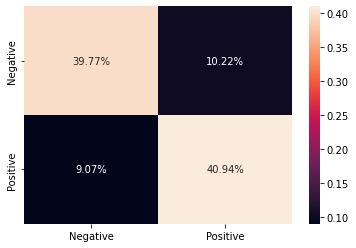

In [ ]:
from catboost.utils import get_confusion_matrix
import seaborn as sns
target_names = ['Negative', 'Positive']
cf_matrix = get_confusion_matrix(model, test_pool)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%',
    xticklabels=target_names,
    yticklabels=target_names)

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report For CatBoost')
target_names = ['Negative', 'Positive']
print(classification_report(
    df_test['target'].astype('category').cat.codes.values,
    y_pred, target_names=target_names))


Classification Report For CatBoost
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.80    239943
    Positive       0.80      0.82      0.81    240057

    accuracy                           0.81    480000
   macro avg       0.81      0.81      0.81    480000
weighted avg       0.81      0.81      0.81    480000

